# Branch-and-prune: roots and constraints

Let's go back to the problem of root finding.
How can we find *all* the roots of a function $f$ over an interval or box $X$ in a guaranteed way?

Standard numerical methods are unable to do this for general functions. [There are methods for polynomials, but they are tricky do implement. [Homotopy continuation](https://www.juliahomotopycontinuation.org) is a particularly powerful technique.]

The combination of working with sets and having Newton-type techniques for verifying (certifying) existence and uniqueness of a simple root in a box allows interval methods to calculate and verify all simple roots.

## Branch and prune

If we wish to locate all of the roots inside a box, we somehow have to *break up* the whole of $X$ into small enough *pieces* $X_i$, such that in each piece we can either:

- Exclude $X_i$ (show there is no root there)
- Prove existence and uniqueness of a root in $X_i$; or
- Give up and say that we don't know

In notebook 4 we saw one way to do this to characterize the sets that do or don't satisfy a **constraint** (inequality): Split up $X$ into tiny boxes of a uniform size. 

Is it possible to improve on that method? We expect neighbouring regions of space to usually "behave the same", so we are doing a lot of unnecessary calculations. In particular when discarding / excluding regions, we want those regions to be as *large* as possible.

### Branching: Bisection

Let's start with the whole of $X$. It is possible that we can exclude the whole of $X$ in one go if $f(X)$ does not contain $0$. 

If $0 \in f(X)$ then as usual we cannot say anything, so let us **bisect** $X$ in that case. The simplest method to bisect a box is to choose the largest dimension and split $X$ in half along that direction. [More sophisticated strategies, such as the **smear heuristic**, which checks which direction is expanded most by $f$, may be superior.]

### Pruning: Exclusion

Once we have bisected, we check each sub-box to see if either can be excluded (or if we can prove that there is a unique root). If it can be excluded we **prune** it, i.e. remove it from consideration.

We repeat these bisection and pruning steps until we reach boxes whose size is some predefined tolerance.

Note that this same technique works for the set inversion problem we saw earlier. Indeed, the condition $f(x) = 0$ for finding a root is special case of an inequality (constraint).

## Regular pavings

We end up with a collection of boxes, which are usually *not* of a uniform size. This is called a **regular paving**: we have "paved" (covered) the set of interest.

In fact, if we keep track of which boxes give rise to which child boxes, we end up building a **binary tree**. It is then possible at the end of the process to unify boxes again to reduce the complexity.

## Implementation

To implement a branch-and-prune algorithm we need to keep track of the boxes that are produced along the way in some kind of data structure. 

A simple way to do this is to have a working vector of boxes. We take a box, say from the start or the end of the vector, that we will work on next. After bisecting, we push the new boxes back onto that working vector. When the working vector is empty, we are done.

#### Exercise
1. Implement this working vector method. You should impose a minimum tolerance. 
You can use the `diam` function to 


2. Use this to locate all roots of $f(x) = x^2 - 2$ and $g(x, y) = (x^2 + y^2 - 1, x + y)$.



3. Add in a check using the Newton method to distinguish those boxes where they *may* be a root from those where there *definitely is* a root.

## Software

The [`IntervalRootFinding.jl`](https://github.com/JuliaIntervals/IntervalRootFinding.jl) package has a careful and reasonably comprehensive implementation of these algorithms. Currently it returns a list of `Root` objects, containing an interval or box, together with a symbolic label indicating whether a unique root was proved to be contained inside the box or not. 

Here are some examples:

In [4]:
using IntervalRootFinding, IntervalArithmetic

In [6]:
rts = roots(x -> x^2 - 2, -10..10)

2-element Array{Root{Interval{Float64}},1}:
 Root([1.41421, 1.41422], :unique)
 Root([-1.41422, -1.41421], :unique)

This proves that there are 2 unique roots in the interval $[-10, 10]$ for the given function. You can extract the intervals with

In [7]:
interval.(rts)

2-element Array{Interval{Float64},1}:
  [1.41421, 1.41422]
 [-1.41422, -1.41421]

and the statuses with

In [8]:
root_status.(rts)

2-element Array{Symbol,1}:
 :unique
 :unique

In some cases it is possible to do this over the *whole real line*:

In [40]:
 rts = roots(x -> x^2 - 2, -∞..∞)   # \infty<TAB>

2-element Array{Root{Interval{Float64}},1}:
 Root([1.41421, 1.41422], :unique)
 Root([-1.41422, -1.41421], :unique)

This is possible since it can exclude the regions "at infinity", as we saw in notebook 2.

The roots are located in intervals of width

In [41]:
diam.(interval.(rts))

2-element Array{Float64,1}:
 5.135562552993633e-8
 4.344406834277947e-9

We can modify the tolerance to get more precise results:

In [51]:
 rts = roots(x -> x^2 - 2, -∞..∞, Newton, 1e-10)   # \infty<TAB>

2-element Array{Root{Interval{Float64}},1}:
 Root([1.41421, 1.41422], :unique)
 Root([-1.41422, -1.41421], :unique)

In [46]:
diam.(interval.(rts))

2-element Array{Float64,1}:
 4.440892098500626e-16
 4.440892098500626e-16

And we can use `BigFloat`s to refine the results:

In [54]:
 rts2 = roots(x -> x^2 - 2, big.(rts), Newton, 1e-50)   # \infty<TAB>

2-element Array{Root{Interval{BigFloat}},1}:
 Root([1.41421, 1.41422]₂₅₆, :unique)
 Root([-1.41422, -1.41421]₂₅₆, :unique)

In [55]:
diam.(interval.(rts2))

2-element Array{BigFloat,1}:
 1.524112649680785917773864716222813616198014964045532390823354725960772835380374e-64
 7.481383234722940305791210498485901437332359902826779846132539228575647982974128e-65

The ability to use infinite intervals depends on the function; for example, the following currently hangs (which should be fixed) since it is unable to exclude regions at infinity:

In [12]:
 # rts = roots(x -> x^2 - 2x, -∞..∞)   # HANGS!

It is not clear (to me) how to robustly exclude regions at infinity, especially for functions in more dimensions.

What happens for complicated functions? For example, $x \mapsto \sin(1/x)$ has an *infinite* number of roots converging to $0$:

In [23]:
f(x) = sin(1 / x)

rts = roots(f, 0..1)

4864-element Array{Root{Interval{Float64}},1}:
 Root([7.44744e-05, 7.45287e-05], :unknown)
 Root([8.51167e-05, 8.5171e-05], :unknown)
 Root([0.000115297, 0.00011535], :unknown)
 Root([8.00789e-05, 8.01341e-05], :unknown)
 Root([0.000374476, 0.000374492], :unknown)
 Root([0.000261543, 0.000261557], :unknown)
 Root([0.000184725, 0.000184742], :unique)
 Root([8.58735e-05, 8.59262e-05], :unknown)
 Root([8.44709e-05, 8.45244e-05], :unknown)
 Root([6.04389e-05, 6.04932e-05], :unknown)
 Root([0.000235088, 0.000235091], :unique)
 Root([0.000128339, 0.000128395], :unknown)
 Root([0.000271595, 0.000271615], :unique)
 ⋮
 Root([0.000227161, 0.000227203], :unknown)
 Root([0.00107175, 0.00107176], :unique)
 Root([0.000120966, 0.000121021], :unknown)
 Root([4.53404e-05, 4.53948e-05], :unknown)
 Root([0.00430145, 0.00430149], :unique)
 Root([0.000277272, 0.000277302], :unknown)
 Root([0.000142768, 0.000142824], :unknown)
 Root([0.000338623, 0.00033867], :unknown)
 Root([0.000165612, 0.000165671], :unk

Let's plot the function and the roots that it has isolated:

In [20]:
using Plots

In [32]:
unique_roots = interval.(rts)[isunique.(rts)];

length(unique_roots)

1295

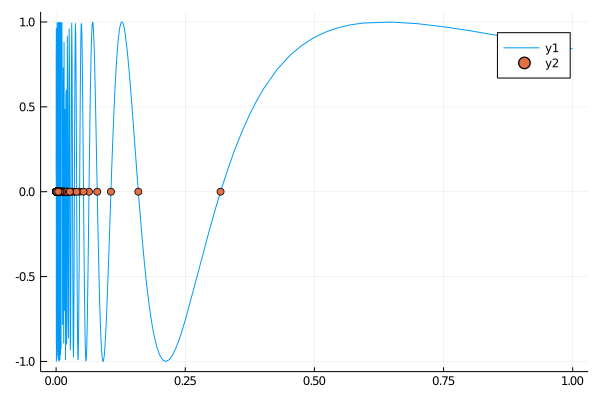

In [27]:
plot(x -> sin(1/x), 0, 1)
scatter!(mid.(unique_roots), zero)

The region where no unique roots are found:

In [31]:
non_unique = rts[(!isunique).(rts)]

reduce(∪, interval.(non_unique))

[0, 0.00195287]

We can increase the number of roots found by decreasing the tolerance:

## Multi-dimensional functions

The `roots` function can also be used to find roots in higher dimensions.


#### Exercise

Find all the roots of the following function taken from the [NLSolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl) README in the box $[-5, 5]^2$.

$$g(x, y) = ( (x+3)(y^3-7)+18, \sin(y \exp(x)-1))$$

Plot the zero level sets of the component functions and plot the roots. How many are there?

## Iteration interface

`IntervalRootFinding.jl` has a sophisticated iteration interface, thanks to Benoît Richard.
This allows you to have fine control over the iteration process through the tree;
see the docs for more details.